# Deutsch–Jozsa on Amazon Braket

This notebook ports the Qiskit version to Amazon Braket and shows how to run on local and AWS-managed simulators, with an optional QPU path.

## 1) Install and Import Amazon Braket SDK

If you're running locally, the cell below installs the Braket SDK and helpers. On AWS Braket notebooks this may already be installed.

In [11]:
# Optional: install packages if missing (safe to rerun)
# Note: If you're on AWS Braket notebook instances, these are preinstalled.
import sys, subprocess

def pip_install(pkg):
    try:
        __import__(pkg)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pkg])

for pkg in ["amazon-braket-sdk", "boto3", "matplotlib"]:
    pip_install(pkg)

from braket.circuits import Circuit
from braket.aws import AwsDevice, AwsQuantumTask, AwsSession
from braket.devices import LocalSimulator
import boto3
import numpy as np
import matplotlib.pyplot as plt

## 2) Configure AWS Credentials and Create Braket Session

Set your region and (optionally) profile. We'll verify access by calling STS and listing a device.

In [12]:
import os
REGION = os.environ.get("AWS_REGION", "us-west-2")
AWS_PROFILE = os.environ.get("AWS_PROFILE", None)  # e.g., "default"

# Optional: set the profile for boto3 session
boto3_session = boto3.Session(profile_name=AWS_PROFILE, region_name=REGION) if AWS_PROFILE else boto3.Session(region_name=REGION)
sts = boto3_session.client("sts")
try:
    ident = sts.get_caller_identity()
    print(f"AWS account: {ident['Account']}, user: {ident.get('Arn','?')}")
except Exception as e:
    print("Warning: Could not verify AWS credentials. Set AWS_PROFILE or configure credentials.")
    print(e)

# Create a Braket session (region comes from the boto3 session)
braket_session = AwsSession(boto_session=boto3_session)
print("Braket session created.")

# Quick device lookup (SV1)
try:
    sv1 = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1", aws_session=braket_session)
    print("SV1 status:", sv1.status())
except Exception as e:
    print("Warning: Could not query SV1 (likely missing credentials or permissions):", e)

Unable to locate credentials
Braket session created.
Braket session created.


## 3) Define Deutsch–Jozsa Oracle in Braket (balanced/constant)

We implement the standard oracle using X pre/post around multi-CNOTs to the ancilla.

In [13]:
from typing import Literal

def dj_oracle(case: Literal["balanced", "constant"], n: int, seed: int | None = 1234) -> Circuit:
    rng = np.random.default_rng(seed)
    c = Circuit()
    anc = n  # use qubit n as ancilla
    if case == "balanced":
        # Choose a non-zero bitmask b in [1, 2^n - 1]
        b = int(rng.integers(1, 2**n))
        b_str = format(b, f"0{n}b")
        # Pre X
        for q, bit in enumerate(b_str):
            if bit == "1":
                c.x(q)
        # CNOT from each input qubit to ancilla
        for q in range(n):
            c.cnot(control=q, target=anc)
        # Post X
        for q, bit in enumerate(b_str):
            if bit == "1":
                c.x(q)
    elif case == "constant":
        output = int(rng.integers(0, 2))
        if output == 1:
            c.x(anc)
    else:
        raise ValueError("case must be 'balanced' or 'constant'")
    return c

## 4) Build Deutsch–Jozsa Circuit (n inputs + 1 ancilla)

Prepare ancilla in |->, apply H on inputs, call the oracle, apply H on inputs, and measure only inputs.

In [14]:
def dj_algorithm(oracle: Circuit, n: int) -> Circuit:
    c = Circuit()
    anc = n
    # Prepare ancilla in |-> = H X |0>
    c.x(anc).h(anc)
    # H on all inputs
    for q in range(n):
        c.h(q)
    # Append oracle (assumes it uses same qubit indexing)
    c += oracle
    # H on inputs again
    for q in range(n):
        c.h(q)
    # Measure inputs only
    for q in range(n):
        c.measure(q)
    return c

## 5) Utility: Normalize Measurement Counts to Input Register

Braket returns bitstrings least-significant-bit first per shot. We'll map to big-endian strings over input qubits only.

In [15]:
from collections import Counter

def normalize_counts_input_only(measurement_counts: dict[str, int], n: int) -> dict[str, int]:
    """
    Convert raw Braket counts (bitstrings include only measured qubits in little-endian)
    to big-endian strings over the n input qubits. Since we measure only inputs [0..n-1],
    we just reverse each key to big-endian.
    """
    norm = Counter()
    for k, v in measurement_counts.items():
        # Braket uses little-endian: reverse to big-endian
        norm[k[::-1]] += v
    return dict(norm)


def prob_of(bitstring: str, counts: dict[str, int]) -> float:
    total = sum(counts.values()) or 1
    return counts.get(bitstring, 0) / total


def plot_hist(counts: dict[str, int], title: str = "Counts"):
    keys = sorted(counts.keys())
    vals = [counts[k] for k in keys]
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(keys)), vals)
    plt.xticks(range(len(keys)), keys, rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()

## 6) Visualize Circuit (ASCII and OpenQASM)

We'll build an example circuit and show its diagram and IR.

In [16]:
# Example visualization for n=5
n_demo = 5
oracle_demo = dj_oracle("balanced", n_demo, seed=42)
dj_demo = dj_algorithm(oracle_demo, n_demo)
print("Circuit diagram:\n")
print(dj_demo)

# IR (OpenQASM 3 when available; otherwise JSON IR)
try:
    ir = dj_demo.to_ir()
    print("\nCircuit IR:\n", ir)
except Exception as e:
    print("IR export not available:", e)

Circuit diagram:

T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │  8  │  9  │
      ┌───┐             ┌───┐                               ┌───┐ 
q0 : ─┤ H ├─────────●───┤ H ├───────────────────────────────┤ M ├─
      └───┘         │   └───┘                               └───┘ 
      ┌───┐         │         ┌───┐                         ┌───┐ 
q1 : ─┤ H ├─────────┼─────●───┤ H ├─────────────────────────┤ M ├─
      └───┘         │     │   └───┘                         └───┘ 
      ┌───┐         │     │         ┌───┐                   ┌───┐ 
q2 : ─┤ H ├─────────┼─────┼─────●───┤ H ├───────────────────┤ M ├─
      └───┘         │     │     │   └───┘                   └───┘ 
      ┌───┐ ┌───┐   │     │     │         ┌───┐ ┌───┐       ┌───┐ 
q3 : ─┤ H ├─┤ X ├───┼─────┼─────┼─────●───┤ X ├─┤ H ├───────┤ M ├─
      └───┘ └───┘   │     │     │     │   └───┘ └───┘       └───┘ 
      ┌───┐ ┌───┐   │     │     │     │         ┌───┐ ┌───┐ ┌───┐ 
q4 : ─┤ H ├─┤ X ├───┼─────┼─────┼─────┼─────

## 7) Run on Local Simulator (braket_sv) and Plot Histogram

We expect constant oracles to yield 0^n with probability ~1; balanced should yield 0^n with probability ~0.

P(0^n) balanced: 0.0


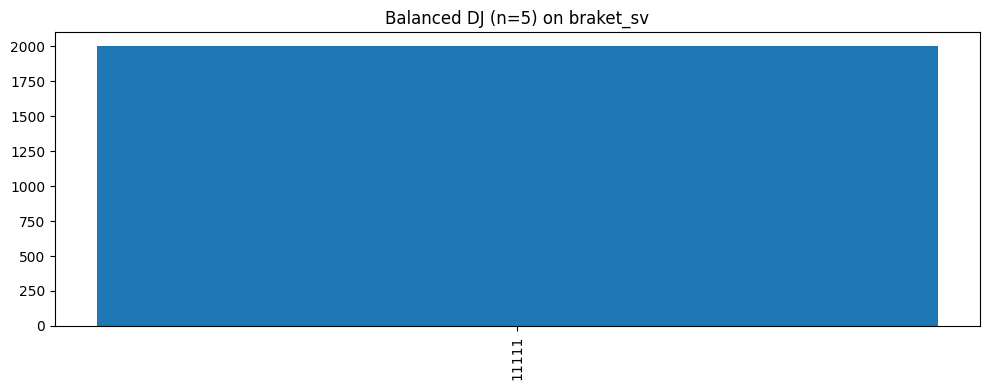

P(0^n) constant: 1.0


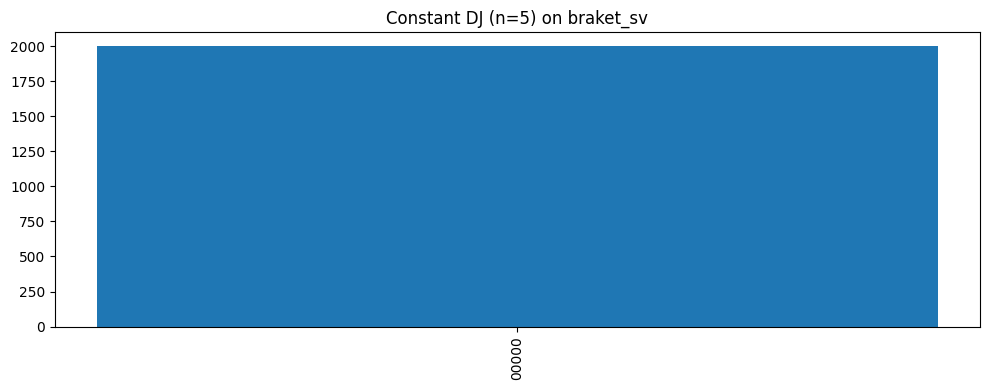

In [17]:
shots = 2000

# Balanced test
n = 5
oracle = dj_oracle("balanced", n, seed=7)
dj_circ = dj_algorithm(oracle, n)
local = LocalSimulator("braket_sv")
res = local.run(dj_circ, shots=shots).result()
counts_balanced = normalize_counts_input_only(res.measurement_counts, n)
print("P(0^n) balanced:", prob_of("0"*n, counts_balanced))
plot_hist(counts_balanced, title=f"Balanced DJ (n={n}) on braket_sv")

# Constant test
oracle_c = dj_oracle("constant", n, seed=7)
dj_circ_c = dj_algorithm(oracle_c, n)
res_c = local.run(dj_circ_c, shots=shots).result()
counts_constant = normalize_counts_input_only(res_c.measurement_counts, n)
print("P(0^n) constant:", prob_of("0"*n, counts_constant))
plot_hist(counts_constant, title=f"Constant DJ (n={n}) on braket_sv")

## 8) Run on Managed Simulator SV1 (AWS) and Plot Histogram

SV1 supports up to around 34 qubits for full statevector. We'll run with a modest n so that n+1 <= 34.

In [20]:
# Configure S3 bucket/prefix for Braket task results
# Ensure the bucket exists in your chosen region and you have write permissions
S3_BUCKET = os.environ.get("BRAKET_S3_BUCKET", "YOUR-BRAKET-BUCKET")
S3_PREFIX = os.environ.get("BRAKET_S3_PREFIX", "braket-dj")

n = 20  # keep n+1 <= ~34 for SV1; adjust as needed
oracle = dj_oracle("balanced", n, seed=123)
dj_circ = dj_algorithm(oracle, n)

sv1_device = "sv1"  # already initialized with session

if S3_BUCKET == "YOUR-BRAKET-BUCKET":
    print("Skipping SV1 submit: set BRAKET_S3_BUCKET and BRAKET_S3_PREFIX to run on AWS.")
else:
    task = sv1_device.run(dj_circ, shots=5000, s3_destination_folder=(S3_BUCKET, S3_PREFIX))
    print("SV1 task id:", task.id)
    result = task.result()
    counts_sv1 = normalize_counts_input_only(result.measurement_counts, n)
    print("P(0^n) on SV1:", prob_of("0"*n, counts_sv1))
    plot_hist(counts_sv1, title=f"Balanced DJ (n={n}) on SV1")

Skipping SV1 submit: set BRAKET_S3_BUCKET and BRAKET_S3_PREFIX to run on AWS.


## 9) Optional: Run on a QPU (edit ARN) with Device Constraints Check

Pick a QPU ARN that supports measurements and gate set compatible with this circuit.

In [ ]:
# Example QPU ARN (commented): adjust to your provider/account availability
# device_arn = "arn:aws:braket:us-west-1::device/qpu/ionq/ionQdevice"
# device_arn = "arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy"
# device_arn = "arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3"

device_arn = None  # set to one of the above to enable

if device_arn and S3_BUCKET != "YOUR-BRAKET-BUCKET":
    qpu = AwsDevice(device_arn, aws_session=braket_session)
    props = qpu.properties
    try:
        n_qubits = props.dict()["paradigm"]["qubitCount"]
    except Exception:
        n_qubits = None
    print("QPU:", qpu.name, "status:", qpu.status(), "qubits:", n_qubits)

    n_qpu = 5  # small to respect connectivity and error rates
    oracle_qpu = dj_oracle("balanced", n_qpu, seed=321)
    dj_qpu = dj_algorithm(oracle_qpu, n_qpu)

    task = qpu.run(dj_qpu, shots=2000, s3_destination_folder=(S3_BUCKET, S3_PREFIX))
    print("QPU task id:", task.id)
    result = task.result()
    counts_qpu = normalize_counts_input_only(result.measurement_counts, n_qpu)
    plot_hist(counts_qpu, title=f"Balanced DJ (n={n_qpu}) on {qpu.name}")
else:
    print("Skipping QPU run. Set device_arn and BRAKET_S3_* to enable.")

## 10) Parameter Sweep over n and Plot Success Metric

We'll sweep several n and report P(0^n) for constant and balanced oracles on a chosen device.

In [ ]:
def run_on_device(circ: Circuit, device, shots: int = 2000, s3=None):
    if isinstance(device, LocalSimulator):
        return device.run(circ, shots=shots).result().measurement_counts
    else:
        task = device.run(circ, shots=shots, s3_destination_folder=s3)
        res = task.result()
        return res.measurement_counts


def try_n(n: int, case: str, device, shots: int = 2000, seed: int = 7, s3=None):
    oracle = dj_oracle(case, n, seed=seed)
    circ = dj_algorithm(oracle, n)
    counts = run_on_device(circ, device, shots=shots, s3=s3)
    counts_norm = normalize_counts_input_only(counts, n)
    p0 = prob_of("0"*n, counts_norm)
    return p0, counts_norm

# Choose device depending on n
use_sv1 = True
if use_sv1 and S3_BUCKET != "YOUR-BRAKET-BUCKET":
    device = sv1_device
    s3_folder = (S3_BUCKET, S3_PREFIX)
else:
    device = LocalSimulator("braket_sv")
    s3_folder = None

ns = [5, 20, 32, 45]
ps_bal, ps_const = [], []
for n in ns:
    # For n > 33, switch to TN1 on AWS or stay local
    if s3_folder and n + 1 > 34:
        device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/tn1", aws_session=braket_session)
    elif not s3_folder:
        device = LocalSimulator("braket_sv")

    p_const, _ = try_n(n, "constant", device, shots=2000, seed=11, s3=s3_folder)
    p_bal, _ = try_n(n, "balanced", device, shots=2000, seed=11, s3=s3_folder)
    ps_const.append(p_const)
    ps_bal.append(p_bal)
    print(f"n={n}: P0(constant)={p_const:.3f}, P0(balanced)={p_bal:.3f}")

plt.figure(figsize=(8,5))
plt.plot(ns, ps_const, marker='o', label='P(0^n) constant')
plt.plot(ns, ps_bal, marker='o', label='P(0^n) balanced')
plt.xlabel('Number of input bits n')
plt.ylabel('Probability')
plt.title('Deutsch–Jozsa success metric across n')
plt.grid(True)
plt.legend()
plt.show()

### Notes and tips
- Set environment variables BRAKET_S3_BUCKET and BRAKET_S3_PREFIX to enable AWS runs.
- Ensure your AWS credentials are configured (AWS_PROFILE or default credentials), and region matches your bucket.
- For n > 33, prefer TN1 instead of SV1. QPUs have much smaller qubit counts; start with n=4..8.
- Costs: Managed simulators and QPUs incur charges; review pricing before running large jobs.